<a href="https://colab.research.google.com/github/Lee-Gunju/Lee-Gunju/blob/master/assign_090.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import chainer as ch
import cupy as cp
import random
from tqdm import tqdm

In [0]:
file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

#
# make a matrix each column of which represents an images in a vector form
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_labels  = np.empty(num_image, dtype=int)

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_labels[count]       = label
    list_image[:, count]    = im_vector

    count += 1

list_label = cp.zeros((10, num_image))
for i in range(num_image):
  list_label[list_labels[i]][i] = 1

In [0]:
def sigmoid(x):
  return cp.reciprocal(1 + np.exp(-x))

def energy(output, label):
  return -((label*cp.log(output) + (1 - label)*cp.log(1 - output)).sum(axis=0)).mean()

def generate(data):
  return cp.vstack((data, cp.ones((1, data.shape[1]))))

def accuracy(pred, label):
  return (pred == label.argmax(axis = 0)).mean()

In [0]:
Layers = [cp.random.normal(loc = 0, scale = 1, size = (196, size_row*size_col + 1)),
          cp.random.normal(loc = 0, scale = 1, size = (49, 197)),
          cp.random.normal(loc = 0, scale = 1, size = (10, 50))]

train_image = list_image[:, :6000]
train_label = list_label[:, :6000]
train_e = [0]
train_acc = []

test_image = list_image[:, 6000:]
test_label = list_label[:, 6000:]
test_e = [0]
test_acc = []

cache = [cp.zeros((196, size_row*size_col + 1)),
     cp.zeros((49, 197)),
     cp.zeros((10, 50))]
beta = 0.999
eps = 1e-8

In [0]:
def running(data, layers):
  h = [generate(data)]
  for layer in layers:
    h.append(generate(sigmoid(layer@h[-1])))
  return h[-1][:-1], h

def backpropagating(label, a, layers, rate):
  sigma = a[3][:-1] - label
  for i in reversed(range(len(Layers))):
    dx = sigma@a[i].transpose()/label.shape[1]
    if cache[i].sum() == 0: cache[i] += dx*dx
    else : cache[i] = beta*cache[i] + (1 - beta)*dx**2
    Layers[i] -= rate*dx/(cp.sqrt(cache[i]) + eps)
    if i != 0 :sigma = (Layers[i].transpose()@sigma*(a[i]*(1-a[i])))[:-1]

In [0]:
train_h, a = running(train_image, Layers)
test_h = running(test_image, Layers)[0]
e = energy(train_h, train_label)
rate = 0.01
epoch = 1000

for i in tqdm(range(epoch)):
  train_e.append(e)
  test_e.append(energy(test_h, test_label))
  train_acc.append(accuracy(train_h.argmax(axis=0), train_label))
  test_acc.append(accuracy(test_h.argmax(axis=0), test_label))
  backpropagating(train_label, a, Layers, rate)
  train_h, a = running(train_image, Layers)
  test_h = running(test_image, Layers)[0]
  e = energy(train_h, train_label)
  if e != e : break

In [0]:
def print_image(image, label):
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.xlabel("label : {}".format(label))

def print_pred(pred, real):
  thisplot = plt.bar(range(10), pred.tolist(), color='k')
  plt.grid(False)
  plt.xticks([0,1,2,3,4,5,6,7,8,9])
  plt.yticks([])
  thisplot[pred.argmax().tolist()].set_color('red')
  thisplot[real.tolist()].set_color('blue')

1. Plot the loss curve



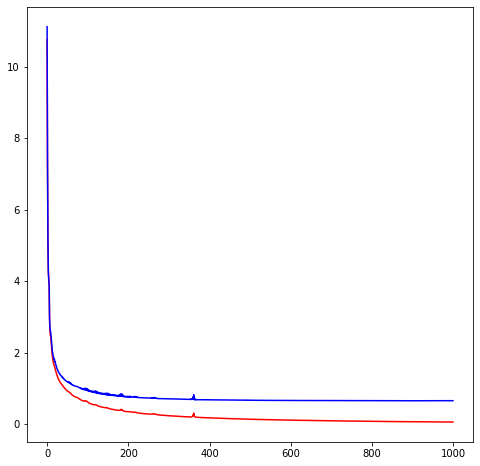

In [25]:
plt.figure(figsize=(8, 8))
plt.plot(range(0, len(train_e) - 1), train_e[1:], c = 'r')
plt.plot(range(0, len(test_e) - 1), test_e[1:], c = 'b')
plt.show()

# 2. Plot the accuracy curve



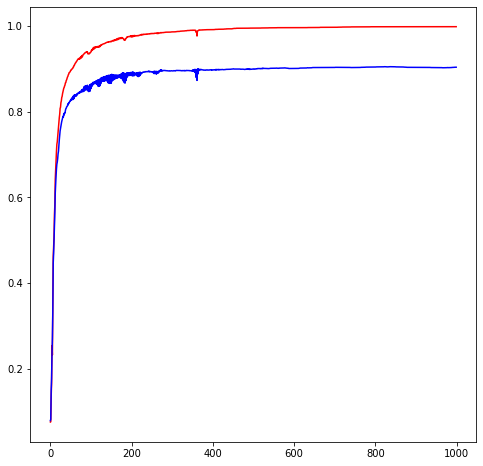

In [26]:

plt.figure(figsize=(8, 8))
plt.plot(range(0, len(train_acc)), train_acc, c = 'r')
plt.plot(range(0, len(test_acc)), test_acc, c = 'b')
plt.show()

3. Plot the accuracy value



In [27]:
print('train accuracy :', accuracy(train_h.argmax(axis=0), train_label)*100,'%')
print('test accuracy  :', accuracy(test_h.argmax(axis=0), test_label)*100, '%')

train accuracy : 99.83333333333333 %
test accuracy  : 90.375 %


4. Plot the classification example



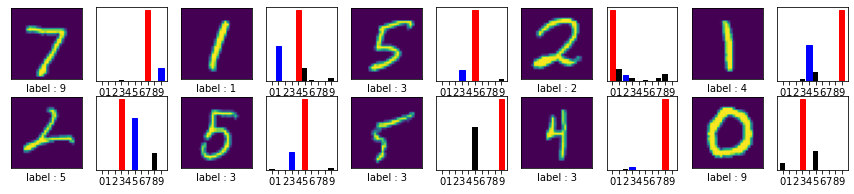

In [28]:
plt.figure(figsize=(15,3))
pred = running(test_image, Layers)[0].transpose()
real = list_labels[6000:]
i = 0
for t in range(len(pred)):
  if pred[t].argmax().tolist() == real[t]: continue
  if i == 10 : break
  plt.subplot(2,10,2*i + 1)
  image = list_image.transpose()[t].reshape((28, 28))
  print_image(image, real[t])
  plt.subplot(2,10,2*i + 2)
  print_pred(pred[t], real[t])
  i += 1
plt.show()

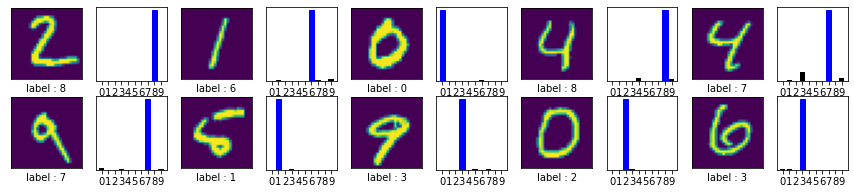

In [29]:
plt.figure(figsize=(15,3))
pred = running(test_image, Layers)[0].transpose()
real = test_label.transpose().argmax(axis = 1)
i = 0
for t in range(len(pred)):
  if pred[t].argmax().tolist() != real[t]: continue
  if i == 10 : break
  plt.subplot(2,10,2*i + 1)
  image = list_image.transpose()[t].reshape((28, 28))
  print_image(image, real[t])
  plt.subplot(2,10,2*i + 2)
  print_pred(pred[t], real[t])
  i += 1
plt.show()